In [1]:
from src.utils import get_project_root
from pyedflib import highlevel
import os

signals, signal_headers, header = highlevel.read_edf(os.path.join(get_project_root(), 'data/ecg/ecg_23.EDF'))

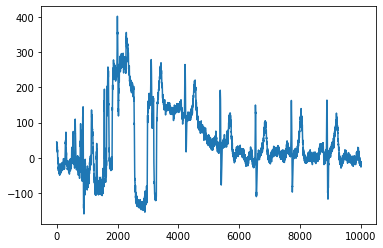

In [2]:
import matplotlib.pyplot as plt

plt.plot(signals[0][240000:250000])

In [3]:
signals, signal_headers, header = highlevel.read_edf(os.path.join(get_project_root(), 'data/ecg/ecg_16.EDF'))

ecg_length = len(signals[0])
print(ecg_length/1000/60/60, " h")

22.170833333333334  h


In [4]:
from scipy.io import loadmat
import os

paths = [path for path in os.listdir(os.path.join(get_project_root(), 'data/')) if
                 path.lower().endswith(".mat")]
paths = [os.path.join(os.path.join(get_project_root(), 'data/'), path) for path in paths]


for path in paths:
    i = path.lower().split("_")[-1].replace(".mat", "")
    mat_dict = loadmat(path)
    bcg_length = len(mat_dict['BCG_raw_data'][0])/100/60/60

    print(i, ": ", "%.2f" % bcg_length, " h")

11 :  22.39  h
13 :  10.47  h
12 :  22.75  h
16 :  23.29  h
17 :  22.36  h
15 :  7.50  h
14 :  12.00  h
6 :  14.69  h
7 :  18.44  h
5 :  23.30  h
4 :  23.74  h
1 :  23.27  h
3 :  24.17  h
9 :  22.10  h
8 :  5.91  h


In [5]:
from data_preparation import DataSet

data = DataSet()

dict_keys(['27', '26', '09', '35', '08', '22', '36', '23', '13', '11', '05', '28', '14', '16'])
dict_keys(['27', '26', '09', '35', '08', '22', '36', '23', '13', '11', '05', '28', '14', '16'])


In [8]:
for series in data.data_series.values():
    print("ID: ", series.patient_id)
    length = series.ecg.length/60/60
    print("ECG length: ", "%.2f" % length)
    length = 0
    for bcg in series.bcg_series.values():
        length += bcg.length/60/60
    print("BCG length: ", "%.2f" % length)
    print("---")

ID:  27
ECG length:  22.85
BCG length:  23.29
---
ID:  26
ECG length:  23.47
BCG length:  19.50
---
ID:  09
ECG length:  18.65
BCG length:  18.44
---
ID:  35
ECG length:  9.41
BCG length:  24.17
---
ID:  08
ECG length:  13.59
BCG length:  14.69
---
ID:  22
ECG length:  21.38
BCG length:  22.75
---
ID:  36
ECG length:  22.60
BCG length:  23.74
---
ID:  23
ECG length:  21.80
BCG length:  10.47
---
ID:  13
ECG length:  23.06
BCG length:  5.91
---
ID:  11
ECG length:  24.22
BCG length:  23.27
---
ID:  05
ECG length:  21.96
BCG length:  23.30
---
ID:  28
ECG length:  22.59
BCG length:  22.36
---
ID:  14
ECG length:  22.34
BCG length:  22.10
---
ID:  16
ECG length:  22.17
BCG length:  22.39
---


In [12]:
import pandas as pd

brueser = pd.read_csv(os.path.join(get_project_root(), 'data/brueser1.csv'))

brueser.describe()

,unique_peaks,medians,qualities
count,1.355760e+05,135576.000000,135563.000000
mean,4.227706e+06,89.701068,1.641608
std,2.386150e+06,45.889985,1.474974
min,0.000000e+00,0.000000,0.000000
25%,2.205110e+06,51.000000,0.444675
50%,4.243035e+06,79.000000,1.300809
75%,6.294841e+06,123.000000,2.464791
max,8.344699e+06,198.000000,17.608716
